## Imports

In [30]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import re
import pandas as pd
import numpy as np
# import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DropZone\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Préparation des données

### organisation données

In [2]:
df = pd.read_csv('./training.1600000.processed.noemoticon.csv', encoding='latin', header=None)

df.head()

0           1                             2         3                4  \
0  0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                   5  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

In [3]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.head()

sentiment          id                          date     query  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

           user_id                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [4]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [5]:
lab_to_sentiment = {0: "Negative", 4: "Positive"}
def label_decoder(label):
    return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head()

sentiment                                               text
0  Negative  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1  Negative  is upset that he can't update his Facebook by ...
2  Negative  @Kenichan I dived many times for the ball. Man...
3  Negative    my whole body feels itchy and like its on fire 
4  Negative  @nationwideclass no, it's not behaving at all....

Text(0.5, 1.0, 'Sentiment Data Distribution')

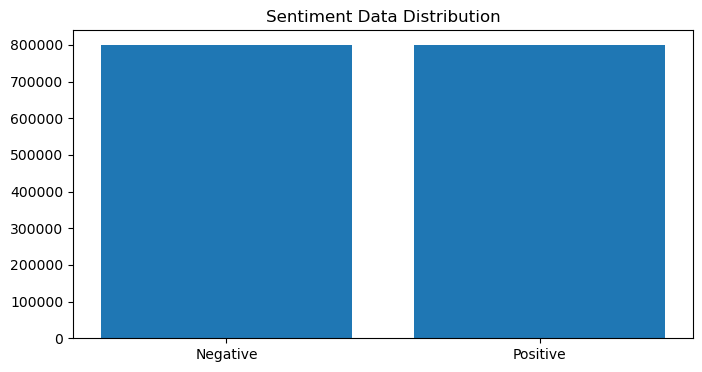

In [6]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [7]:
import random
random_idx_list = [ random.randint(1, len(df.text)) for i in range(10)]

df.loc[random_idx_list,:].head(10)

sentiment                                               text
217944   Negative  My little sister graduates tomorrow. Damn time...
311781   Negative  I got a haircut last Sunday..aww! my hair is s...
580745   Negative  @tidesandclouds  I'm gonna come out there for ...
92994    Negative             Goodnight Mohegan Sun. Enjoy my money 
704990   Negative                     Ended up not getting the car. 
108612   Negative  Can someone tell Sean Kingston to stop gasin h...
1579555  Positive  @terrellowens81 Doing promotion for the show? ...
1341241  Positive  gonna try and work on some photos today &amp; ...
647195   Negative  http://twitpic.com/7si81 - @MikaFonacier @Mill...
1555254  Positive                     out with becky in her new car

### nettoyage des tweets

##### Stemming/Lematization

Radicalisation de mots : Les mots devront être réduits à leur forme radicale. Par exemple, "discount", "discounts", "discounted" et "discounting" devront être tous remplacé par " discount", et "include", "includes", "included", et "ncluded" devront être tous remplacés par « includ ». 

The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.

Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word

Hyperlinks and Mentions

In [8]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [9]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [10]:
df.text = df.text.apply(lambda x: preprocess(x))

##### Positive Words

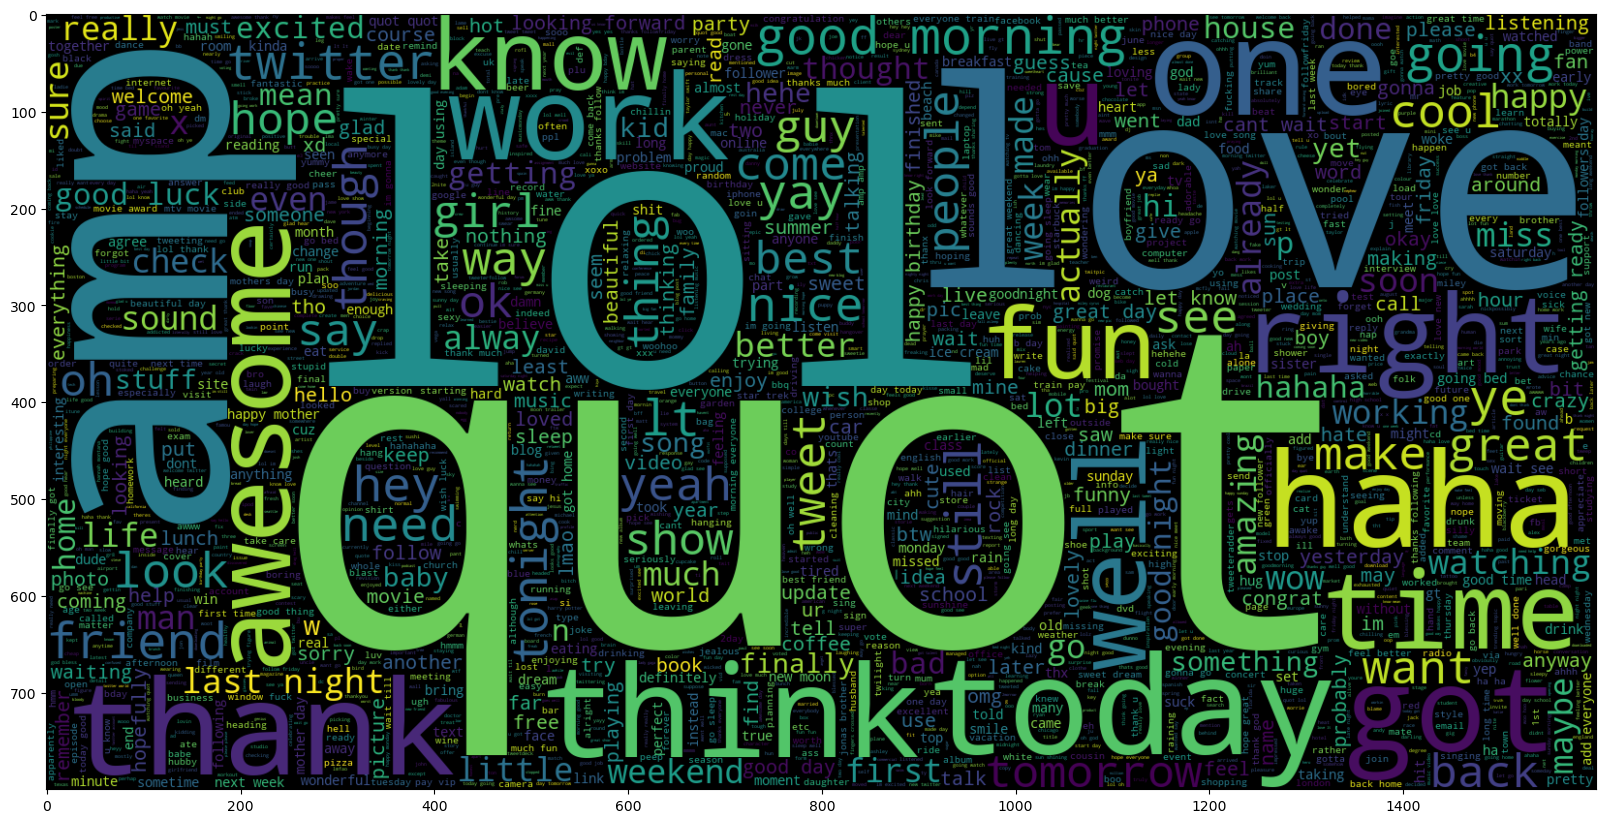

In [27]:
from wordcloud import WordCloud

plt.figure(figsize= (20,20))
wc = WordCloud(max_words= 2000, width= 1600, height= 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc, interpolation= 'bilinear')

##### Negative Words

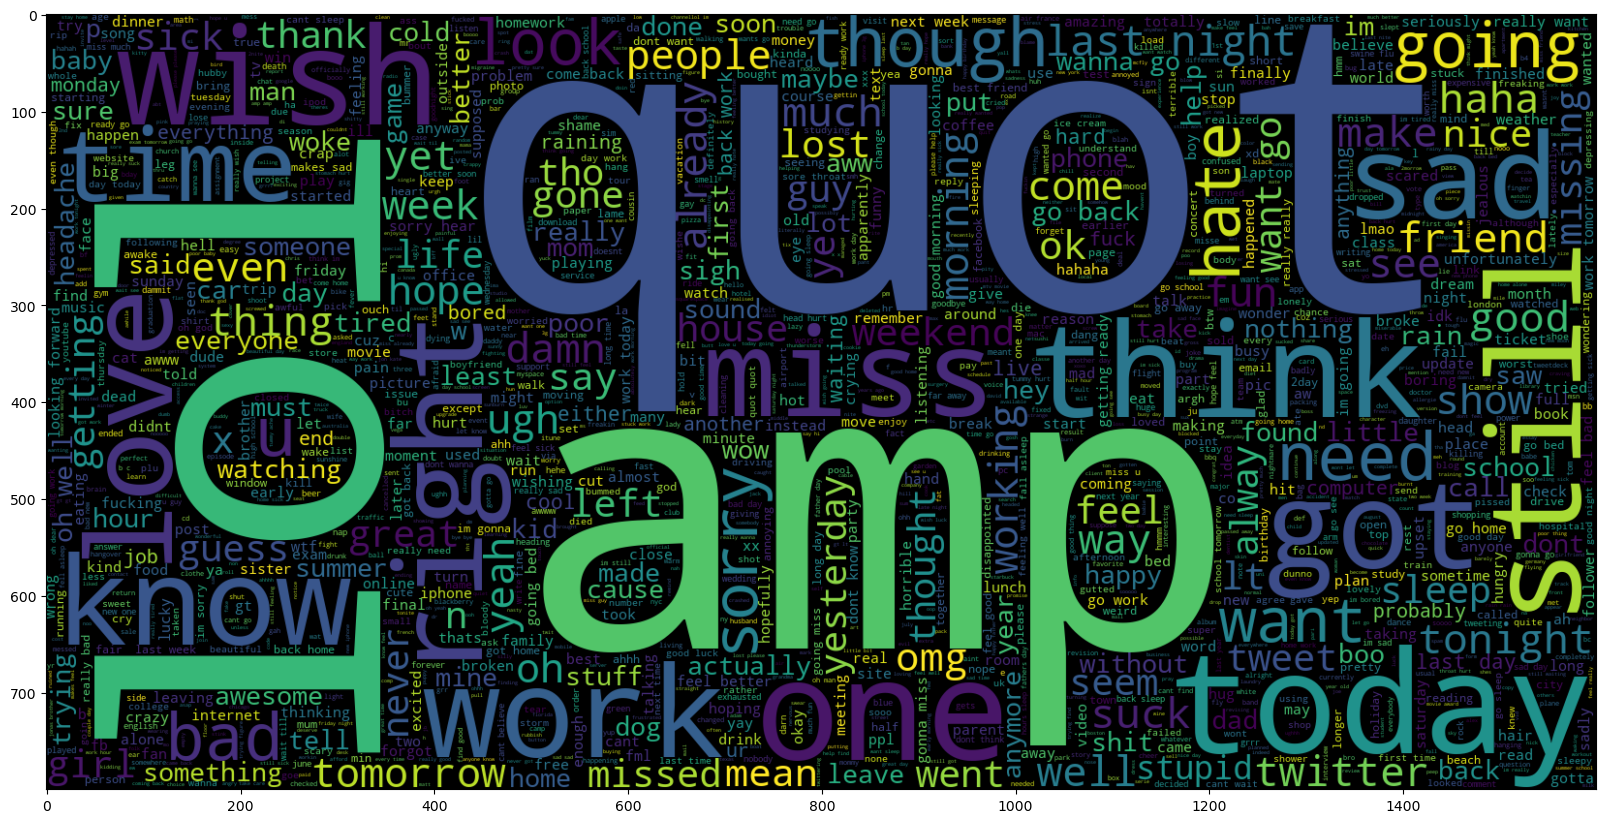

In [28]:
plt.figure(figsize= (20,20))
wc = WordCloud(max_words= 2000, width= 1600, height= 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc, interpolation= 'bilinear')

##### Train and Test Split

In [11]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30 

In [12]:
train_set, test_set = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=7)
print("Train set size:", len(train_set))
print("Test set size:", len(test_set))

Train set size: 1280000
Test set size: 320000


In [13]:
train_set.head(10)

sentiment                                               text
23786    Negative                                       need friends
182699   Negative                          im trying call impossible
476661   Negative  good pace going 3k 13 min missed 5k turn ended...
1181490  Positive               u gonna shows ny soon luv see u live
878773   Positive  hell yea get em tattoos ink free wish parents ...
130866   Negative  yeah need 2 see ur mom calls back first rememb...
1235876  Positive                           sounds like cup tea sign
717314   Negative                               tired want sleep wtf
969880   Positive                                       amazing wish
748698   Negative  thank god wkrn abc affiliate nashville back mi...

##### Construction du vocabulaire 

In [44]:
from keras_preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_set.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size: ", vocab_size)

Vocabulary Size:  290575


In [43]:
# for word, index in tokenizer.word_index.items():
    # print(index, word)

good 1
day 2
get 3
like 4
go 5
quot 6
today 7
going 8
work 9
love 10
got 11
lol 12
time 13
back 14
u 15
one 16
know 17
im 18
really 19
amp 20
see 21
still 22
night 23
well 24
want 25
new 26
2 27
think 28
home 29
thanks 30
oh 31
much 32
miss 33
need 34
last 35
tomorrow 36
morning 37
great 38
hope 39
3 40
twitter 41
haha 42
feel 43
sad 44
wish 45
fun 46
sleep 47
would 48
bad 49
right 50
sorry 51
happy 52
tonight 53
come 54
make 55
way 56
gonna 57
though 58
getting 59
nice 60
better 61
watching 62
yeah 63
week 64
could 65
wait 66
bed 67
school 68
people 69
hate 70
days 71
hey 72
even 73
next 74
dont 75
awesome 76
yes 77
4 78
lt 79
weekend 80
soon 81
never 82
thank 83
cant 84
long 85
take 86
first 87
please 88
working 89
wanna 90
little 91
everyone 92
sick 93
say 94
best 95
tired 96
ok 97
life 98
show 99
watch 100
done 101
1 102
x 103
already 104
thing 105
feeling 106
sure 107
let 108
cool 109
always 110
another 111
guys 112
friends 113
us 114
made 115
ready 116
something 117
find 118
man 

In [32]:
from keras_preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_set.text), maxlen= MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_set.text), maxlen= MAX_SEQUENCE_LENGTH)
print("Training X shape: ", x_train.shape)
print("Testing X shape: ", x_test.shape)

Training X shape:  (1280000, 30)
Testing X shape:  (320000, 30)


In [33]:
labels = train_set.sentiment.unique().tolist()

In [34]:
encoder = LabelEncoder()
encoder.fit(train_set.sentiment.to_list())

y_train = encoder.transform(train_set.sentiment.to_list())
y_test = encoder.transform(test_set.sentiment.to_list())

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

y_train shape:  (1280000, 1)
y_test shape:  (320000, 1)


In [35]:
import subprocess
subprocess.run(['unzip', 'glove.6B.zip'])

CompletedProcess(args=['unzip', 'glove.6B.zip'], returncode=0)

In [36]:
GLOVE_EMB = 'glove.6B/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = ''

In [37]:
embedding_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embedding_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embedding_index))

Found 400000 word vectors.


In [38]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [39]:
# embedding_layer = tf.keras.layers.Embedding(vocab_size)
print(x_train)

[[   0    0    0 ...    0   34  110]
 [   0    0    0 ...  133  220 2319]
 [   0    0    0 ... 5649 9960 1060]
 ...
 [   0    0    0 ...  118 1157  687]
 [   0    0    0 ...    1  247  107]
 [   0    0    0 ...  665 1308 1868]]
